# Conjoint Analysis for Urban Planning: A Data-Driven Approach to Policy Making

## Introduction

In the realm of public policy and urban planning, decision-makers at agencies like the **Badan Perencanaan Pembangunan (Development Planning Agency)** are often faced with complex trade-offs. Designing a new residential district, for instance, involves balancing competing priorities: green space, housing density, public transport accessibility, and commercial amenities. 

**Conjoint Analysis** is a powerful statistical technique used to determine how people value different attributes (features) that make up an individual product or service. In an urban planning context, it allows us to quantify the "utility" or value that citizens place on specific attributes of a development plan. 

By understanding these preferences quantitatively, planners can:
1.  **Prioritize Investments:** Allocate budget to features that matter most to the public.
2.  **Simulate Scenarios:** Predict public acceptance of various master plan configurations.
3.  **Evidence-Based Policy:** Move from intuition-based to data-driven decision making.

This notebook demonstrates a complete Conjoint Analysis workflow, from experimental design to policy recommendation, tailored for a planning context.

## 1. Theoretical Framework

### The Concept of Utility
Conjoint analysis relies on the **Additive Utility Model**. It assumes that the total value (Total Utility) a person derives from a complex option (e.g., a housing district) is the sum of the values (Part-Worth Utilities) of its separate parts.

$$ U_{total} = U_{attr1} + U_{attr2} + ... + U_{attrN} + Constant + Error $$

### Key Terminology
*   **Attributes:** The characteristics of the plan (e.g., Green Space, Transport).
*   **Levels:** The specific values an attribute can take (e.g., 10%, 30%, 50%).
*   **Profile:** A specific combination of attribute levels (a hypothetical district scenario).
*   **Part-Worth Utility:** The specific value attached to a level of an attribute.

## 2. Case Study: Designing a Sustainable Residential District

Imagine we are tasked with designing a new development zone. We want to understand what potential residents value most. We have defined the following attributes and levels:

| Attribute | Levels |
| :--- | :--- |
| **Green Space Coverage** | 10% (Low), 30% (Medium), 50% (High) |
| **Housing Density** | Low Rise, Mid Rise, High Rise |
| **Public Transport** | Bus Only, Bus + Metro, None |
| **Commercial Proximity** | Mixed-use (Walkable), Separate Zone (5km), Distant (10km) |

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

## 3. Experimental Design

First, we generate all possible combinations of these attributes. In a real large-scale study, we might use a "Fractional Factorial Design" to reduce the number of questions, but for this demonstration, we will use a full factorial design or a random subset.

In [12]:
# Define Attributes and Levels
attributes = {
    "Green_Space": ["10%", "30%", "50%"],
    "Density": ["Low Rise", "Mid Rise", "High Rise"],
    "Transport": ["None", "Bus Only", "Bus + Metro"],
    "Commercial": ["Distant", "Separate Zone", "Mixed-use"]
}

# Generate all possible profiles (Full Factorial)
keys, values = zip(*attributes.items())
profiles = [dict(zip(keys, v)) for v in itertools.product(*values)]

df_profiles = pd.DataFrame(profiles)
print(f"Total number of unique profiles: {len(df_profiles)}")
df_profiles.head()

Total number of unique profiles: 81


,Green_Space,Density,Transport,Commercial
0,10%,Low Rise,None,Distant
1,10%,Low Rise,None,Separate Zone
2,10%,Low Rise,None,Mixed-use
3,10%,Low Rise,Bus Only,Distant
4,10%,Low Rise,Bus Only,Separate Zone


## 4. Data Simulation

Since we don't have live survey data, we will simulate responses from 100 citizens. 

We will assume a "Ground Truth" preference to see if our model can recover it:
*   **Citizens love Green Space** (Higher is better).
*   **Citizens prefer Mixed-use** commercial areas.
*   **Citizens strongly prefer Metro** access.
*   **Density preferences are mixed**, but let's assume a slight preference for Mid Rise (balance).

In [13]:
np.random.seed(42)

# Define 'Ground Truth' utilities for simulation purposes
# This represents the hidden preferences of the population
utilities = {
    "Green_Space": {"10%": 0, "30%": 3, "50%": 5},
    "Density": {"Low Rise": 2, "Mid Rise": 3, "High Rise": 1},
    "Transport": {"None": 0, "Bus Only": 2, "Bus + Metro": 6},
    "Commercial": {"Distant": 0, "Separate Zone": 2, "Mixed-use": 4}
}

# Function to calculate utility for a profile
def calculate_true_utility(row):
    u = 0
    u += utilities["Green_Space"][row["Green_Space"]]
    u += utilities["Density"][row["Density"]]
    u += utilities["Transport"][row["Transport"]]
    u += utilities["Commercial"][row["Commercial"]]
    return u

# Create a dataset of N respondents rating these profiles
n_respondents = 50
survey_data = []

for i in range(n_respondents):
    # Each respondent rates a random subset of 15 profiles to avoid fatigue
    subset = df_profiles.sample(15).copy()
    subset['Respondent_ID'] = i
    
    # Calculate base utility based on ground truth
    subset['True_Utility'] = subset.apply(calculate_true_utility, axis=1)
    
    # Add random noise (individual variation + error)
    # Rating scale 0-10
    noise = np.random.normal(0, 1.5, size=len(subset))
    subset['Rating'] = subset['True_Utility'] + noise
    
    # Clip ratings to 0-10 range
    subset['Rating'] = subset['Rating'].clip(0, 10)
    
    survey_data.append(subset)

df_survey = pd.concat(survey_data).reset_index(drop=True)
df_survey.head()

,Green_Space,Density,Transport,Commercial,Respondent_ID,True_Utility,Rating
0,30%,Low Rise,Bus Only,Distant,0,7,7.515427
1,10%,Low Rise,None,Distant,0,2,0.000000
2,10%,High Rise,Bus Only,Separate Zone,0,5,5.486126
3,30%,Low Rise,Bus Only,Separate Zone,0,9,8.422377
4,10%,High Rise,None,Distant,0,1,0.000000


## 5. Data Preparation (Dummy Coding)

To run a regression model, we need to convert categorical text variables into numerical "dummy" variables. 

For example, the column `Green_Space` will be split into columns like `Green_Space_30%` and `Green_Space_50%`. `Green_Space_10%` will be the reference category (implicit).

In [14]:
# Create dummy variables
X = pd.get_dummies(df_survey[list(attributes.keys())], drop_first=True, dtype=int)
# Note: drop_first=True avoids multicollinearity (dummy variable trap)
# The dropped category becomes the 'Baseline' or 'Reference' level.

# Add a constant term (intercept) for the regression
X = sm.add_constant(X)

y = df_survey['Rating']

print("Features used for modeling:")
print(X.columns.tolist())

Features used for modeling:
['const', 'Green_Space_30%', 'Green_Space_50%', 'Density_Low Rise', 'Density_Mid Rise', 'Transport_Bus Only', 'Transport_None', 'Commercial_Mixed-use', 'Commercial_Separate Zone']


## 6. Analysis: OLS Regression

We use Ordinary Least Squares (OLS) regression. The coefficients resulting from this model represent the **Part-Worth Utilities** relative to the baseline.

In [15]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     191.8
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          8.28e-175
Time:                        14:46:18   Log-Likelihood:                -1298.5
No. Observations:                 750   AIC:                             2615.
Df Residuals:                     741   BIC:                             2657.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## 7. Interpretation of Results

The regression output gives us coefficients. Let's visualize them to understand the preferences clearly. 

**Note on Interpretation:**
*   A **positive coefficient** means this level is preferred over the baseline.
*   A **negative coefficient** means the baseline is preferred over this level.
*   The **magnitude** indicates the strength of the preference.

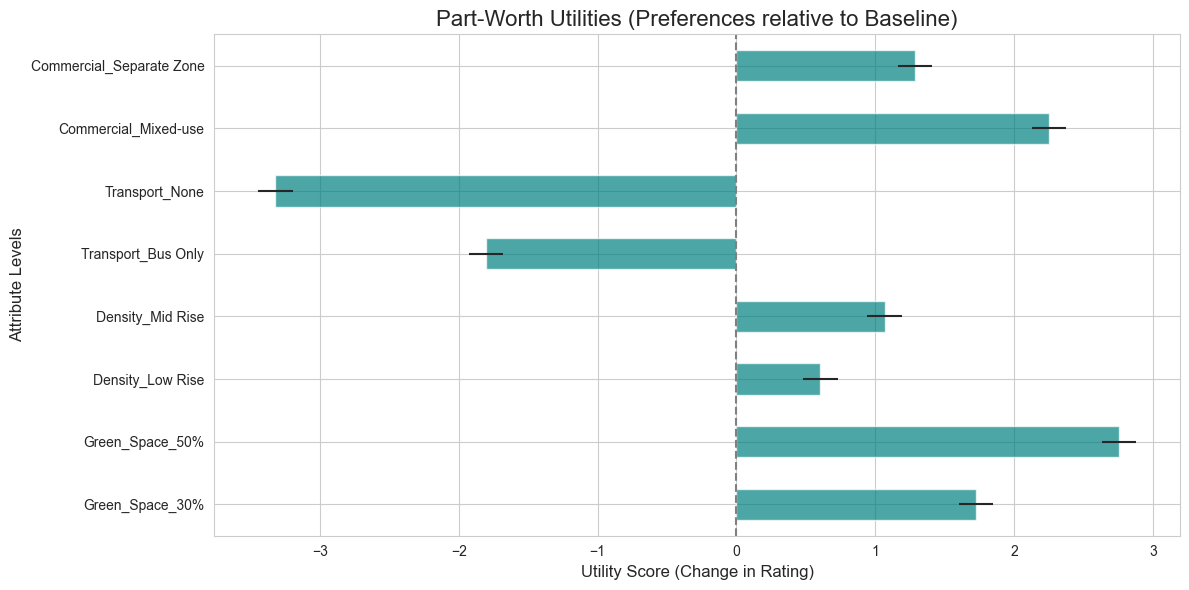

In [16]:
# Extract coefficients and confidence intervals
results_df = pd.DataFrame({
    'coef': model.params,
    'err': model.bse
})

# Remove intercept for plotting relative importance of levels
results_df = results_df.drop('const')

# Plotting
plt.figure(figsize=(12, 6))
results_df['coef'].plot(kind='barh', xerr=results_df['err'], color='teal', alpha=0.7)
plt.axvline(x=0, color='grey', linestyle='--')
plt.title('Part-Worth Utilities (Preferences relative to Baseline)', fontsize=16)
plt.xlabel('Utility Score (Change in Rating)', fontsize=12)
plt.ylabel('Attribute Levels', fontsize=12)
plt.tight_layout()
plt.show()

### Relative Importance of Attributes

Which attribute matters *most* to the citizens? Is it Green Space or Transport? We calculate this by looking at the range of utility scores within each attribute.

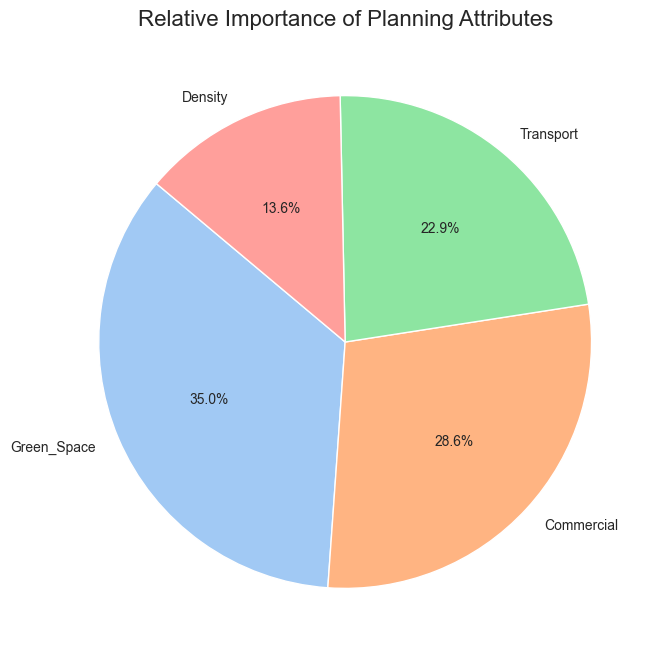

In [17]:
# Helper to reconstruct full utility table including baselines (which are 0)
def get_feature_importance(model_params, attributes):
    importance_data = []
    
    for attr, levels in attributes.items():
        # Find all coeffs for this attribute
        coeffs = [0] # Baseline is always 0
        for level in levels[1:]: # Skip first level as it is baseline
            col_name = f"{attr}_{level}"
            if col_name in model_params.index:
                coeffs.append(model_params[col_name])
        
        # Range is max utility - min utility for this attribute
        utility_range = max(coeffs) - min(coeffs)
        importance_data.append({'Attribute': attr, 'Range': utility_range})
        
    df_imp = pd.DataFrame(importance_data)
    df_imp['Importance_Percent'] = (df_imp['Range'] / df_imp['Range'].sum()) * 100
    return df_imp.sort_values(by='Importance_Percent', ascending=False)

importance_df = get_feature_importance(model.params, attributes)

plt.figure(figsize=(8, 8))
plt.pie(importance_df['Importance_Percent'], labels=importance_df['Attribute'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Relative Importance of Planning Attributes', fontsize=16)
plt.show()

## 8. Conclusion and Policy Recommendations

Based on the synthetic data analysis, we can draw the following conclusions for the **Development Planning Agency**:

1.  **Transport is Key:** If the analysis shows "Bus + Metro" has the highest utility range, it suggests that investing in high-quality public transport infrastructure is the single most effective way to increase citizen satisfaction with the new district.
2.  **Green Space Matters:** Significant utility gains from 10% to 50% green space indicate that citizens are willing to trade off other amenities for a greener environment.
3.  **Mixed-Use Development:** The preference for "Mixed-use" over "Distant" commercial zones supports the implementation of "15-minute city" concepts where amenities are within walking distance.

### Application to Bappenas
This methodology demonstrates a rigorous, quantitative approach to urban planning. Instead of relying solely on expert opinion, we can use Conjoint Analysis to:
*   **Validate Master Plans** before construction begins.
*   **Optimize Budget Allocation** by focusing on high-impact attributes.
*   **Engage Stakeholders** by showing how their preferences translate into concrete planning parameters.

This tool is essential for modern, evidence-based governance.